In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.datacollection import DataCollector


In [85]:
class VoterAgent(CellAgent): 
    """ Voter agent with a party preference. """

    def __init__(self, model, cell):
        super().__init__(model)
        self.political_opinion = np.random.choice([0, 1])
        self.political_bias = np.random.uniform(0, 100) ## 
        self.susceptibility = np.random.uniform(0, 1)
        self.switched_this_step = False
        self.cell = cell

    def move(self):
        """ Move to a random neighboring cell. """    
        self.cell = self.cell.neighborhood.select_random_cell()

    def evaluate_opinion(self):
        """ Evaluate and possibly change political opinion. """
        if self.political_bias < 50:
            self.political_opinion = 0
        else: 
            self.political_opinion = 1

    def policy_influence(self, policy_bias):
        """ Influence from policies. """
        self_bias = self.political_bias
        if abs(policy_bias - self_bias) < 50: ###
            self.political_bias = self_bias + self.susceptibility * (policy_bias - self_bias)

    def media_influence(self, media_bias):
        """ Influence from media. """
        self.political_bias = self.political_bias + self.susceptibility * media_bias

    def interact(self):
        """ Interact with other agents in the same cell. """
        others = [agent for agent in self.cell.agents if agent != self]
        if others:
            other = self.random.choice(others)
            self.policy_influence(other.political_bias)

        previous_opinion = self.political_opinion
        self.evaluate_opinion()
        self.switched_this_step = (self.political_opinion != previous_opinion)
        

In [86]:
def mean_bias(model):
    return np.mean([a.political_bias for a in model.agents])

def var_bias(model):
    return np.var([a.political_bias for a in model.agents])

def switching_rate(model):
    # fraction of agents that switched this step
    vals = [getattr(a, "switched_this_step", False) for a in model.agents]
    return float(np.mean(vals))

# import networkx as nx

# def share_red(model):
#    vals = [a.political_opinion for a in model.schedule.agents]
#    return float(np.mean(vals))  # if Red=1, Blue=0

# def neighbor_disagreement(model):
#    G = model.graph
#    diffs = []
#    for a in model.schedule.agents:
#        nbrs = list(G.neighbors(a.pos)) if hasattr(a, "pos") else []
#        if not nbrs:
#            continue
#        nbr_bias = np.mean([b.political_bias for b in model.net_grid.get_cell_list_contents(nbrs)])
#        diffs.append(abs(a.political_bias - nbr_bias))
#    return float(np.mean(diffs)) if diffs else 0.0

#def assortativity_by_opinion(model):
    # Requires node attribute 'opinion' on graph nodes each step
    # For NetworkGrid, map agent state to node attribute then use attribute assortativity:
#    for node in model.graph.nodes:
#        agents = model.net_grid.get_cell_list_contents([node])
#        model.graph.nodes[node]['opinion'] = int(np.round(np.mean([ag.political_opinion for ag in agents]))) if agents else 0
    # Using degree assortativity is built-in; for attributes, compute mixing matrices or use net libs.
    # Here: fallback—compute degree assortativity as a proxy:
#    return float(nx.degree_assortativity_coefficient(model.graph))

#def modularity_same_opinion(model):
    # Simple community partition by majority opinion per node
#    comms = {}
#    for node in model.graph.nodes:
#        o = model.graph.nodes[node].get('opinion', 0)
#        comms.setdefault(o, set()).add(node)
#    communities = [c for c in comms.values() if c]
#    if len(communities) <= 1:
#        return 0.0
#    try:
#        import networkx.algorithms.community as nxcom
#        return float(nxcom.quality.modularity(model.graph, communities))
#    except Exception:
#        return 0.0

In [87]:
class Environment(mesa.Model):
    """ Environment with a grid of cells. """

    def __init__(self, n, width, height, seed=None):
        super().__init__()
        self.seed = seed
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), 
            torus=True, 
            capacity=10, 
            random=self.random
        )

        VoterAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = DataCollector(
            model_reporters={
                "mean_bias": mean_bias,
                "var_bias": var_bias,
                "switching_rate": switching_rate,
            },
            agent_reporters={
                "political_bias": lambda a: a.political_bias,
                "political_opinion": lambda a: a.political_opinion,
                "susceptibility": lambda a: a.susceptibility,
                "switched":  lambda a: getattr(a, "switched_this_step", False),
            },
        )

        self.datacollector.collect(self)


    def step(self):
        """ Advance the model by one step. """
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("interact")
        self.datacollector.collect(self)

    def media_campaign(self, bias):
        """ Conduct a media campaign with a specific bias. """
        self.agents.do("media_influence", bias)
        

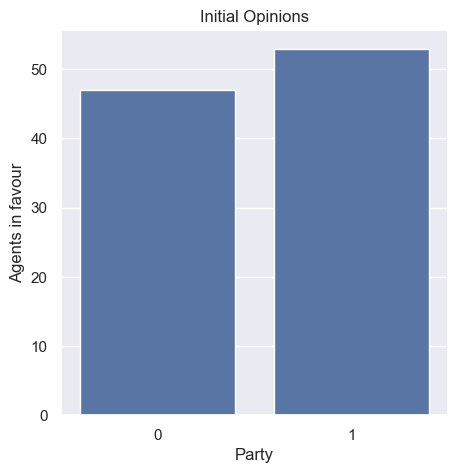

In [88]:
environment = Environment(100, 10, 10)

initial_votes = [agent.political_opinion for agent in environment.agents]
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Opinions", xlabel="Party", ylabel="Agents in favour")
p.figure.set_size_inches(5, 5)

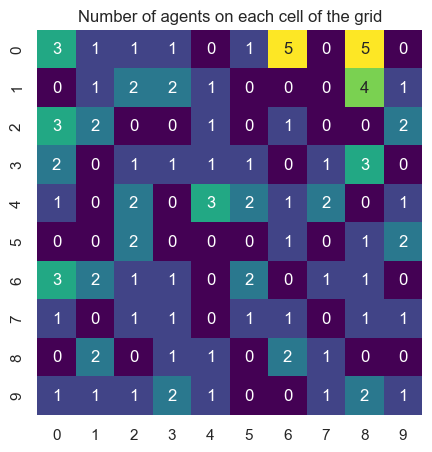

In [89]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

In [90]:
for _ in range(100):
    environment.step()  
    #if _ == 50:
    #    environment.media_campaign(bias=50)

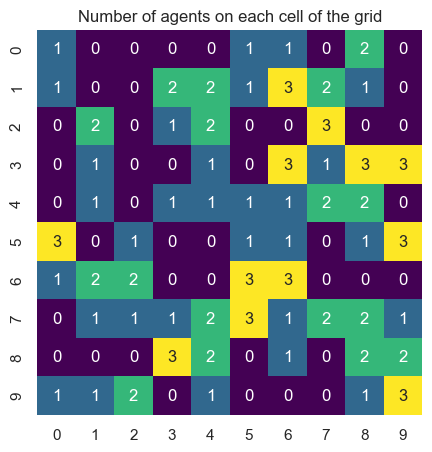

In [91]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

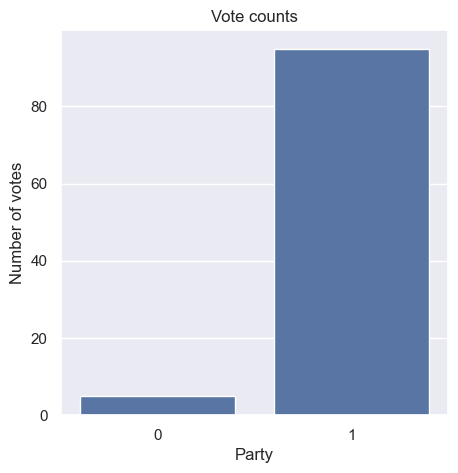

In [92]:
all_votes = [agent.political_opinion for agent in environment.agents]
vote_counts = pd.Series(all_votes).value_counts().sort_index()
g = sns.barplot(x=vote_counts.index, y=vote_counts.values)
g.set(title="Vote counts", xlabel="Party", ylabel="Number of votes")
g.figure.set_size_inches(5, 5)


In [93]:
model_df = environment.datacollector.get_model_vars_dataframe()
agent_df = environment.datacollector.get_agent_vars_dataframe()


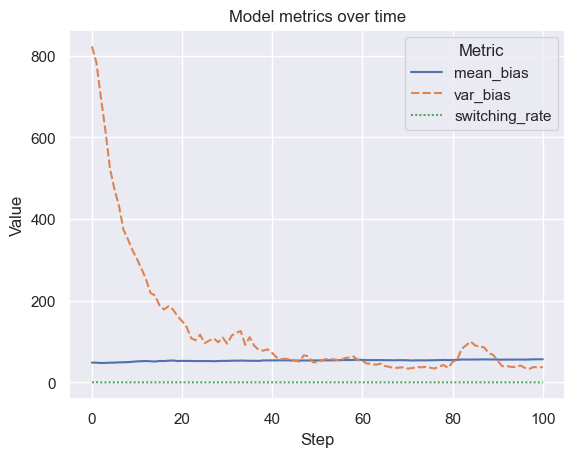

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Or to plot several metrics at once (if you have them):
sns.lineplot(data=model_df)  # will plot each column separately
plt.title("Model metrics over time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend(title="Metric")
plt.show()

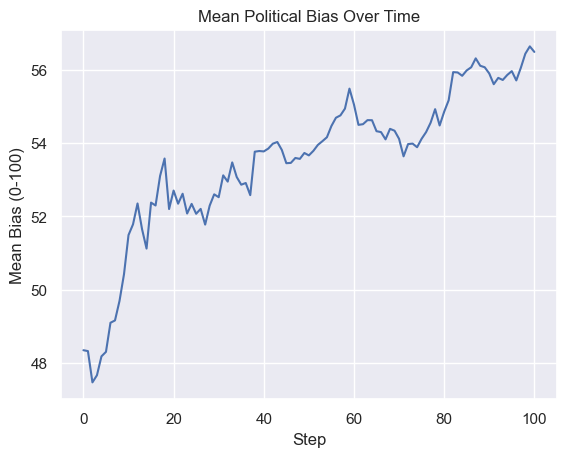

In [95]:
# If you want just one metric (e.g. mean_bias) over time:
sns.lineplot(data=model_df["mean_bias"])
plt.title("Mean Political Bias Over Time")
plt.xlabel("Step")
plt.ylabel("Mean Bias (0-100)")
plt.show()

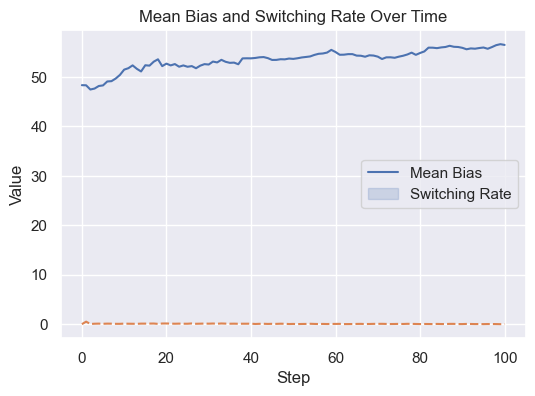

In [96]:
# Or plot both together
plt.figure(figsize=(6,4))
sns.lineplot(data=model_df[["mean_bias", "switching_rate"]])
plt.title("Mean Bias and Switching Rate Over Time")
plt.xlabel("Step")
plt.ylabel("Value")
plt.legend(["Mean Bias", "Switching Rate"])
plt.show()